<a href="https://colab.research.google.com/github/awitz23/master_thesis/blob/main/working_prototype_2_encodings_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#dependencies

In [ ]:
!pip install scikit-learn
from sklearn.ensemble import RandomForestClassifier


In [ ]:
!pip install pm4py
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import os
import sys
import pm4py
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import random
# Pfad zu einem Ordner mit mehreren Dateien


In [ ]:

import pandas as pd
import pm4py
data_path = r"/content/drive/MyDrive/BPI_Challenge_2017.xes.gz"

In [ ]:

if __name__ == "__main__":
    log = pm4py.read_xes(data_path)

df = log

In [ ]:
log1 = log

In [ ]:
log=df

In [ ]:
len(df)

In [ ]:
#log= df[df['concept:name'].str.startswith('W_')]


#print(log)

#Get Data to predict

In [ ]:
list_all_id = log['case:concept:name'].tolist()


In [ ]:
print(list_all_id[:60])

In [ ]:
set_id = set(list_all_id)

In [ ]:
pred_id = random.sample(set_id,1)
print(pred_id)

In [ ]:
pred_id = ''.join(map(str, pred_id))

In [ ]:
print(pred_id)

In [ ]:
log = log.drop(log.loc[log['case:concept:name']==pred_id].index, inplace=False)


In [ ]:
pred_id_df = df.loc[df['case:concept:name']==pred_id]

In [ ]:
#generate log prefixes for all events that end with "A_Pending", last events, after "A_Pending" are deleted
#in the end, keep a df of all traces that end with A_Pending

from random import randrange
r = random.randint(19,20)
print(r)

from pm4py.objects.log.obj import EventLog, Trace
# generate prefixes, note that we need to add the casts to EventLog and Trace to make sure that the result is a PM4Py EventLog object
pred_id_df_prefixes_Accepted = pm4py.filter_prefixes(pred_id_df, 'A_Pending', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
pred_id_df_prefixes_Denied = pm4py.filter_prefixes(pred_id_df, 'A_Denied', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
pred_id_df_prefixes_Cancelled = pm4py.filter_prefixes(pred_id_df, 'A_Cancelled', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')

pred_id_df_prefixes_Accepted["label"] = "accepted"
pred_id_df_prefixes_Cancelled["label"] = "not"
pred_id_df_prefixes_Denied["label"] = "not"

#generate df of log prefixes with length = value in length
trimmed_pred_id_df_Accepted = pm4py.get_prefixes_from_log(pred_id_df_prefixes_Accepted, length=r, case_id_key='case:concept:name')
trimmed_pred_id_df_Denied = pm4py.get_prefixes_from_log(pred_id_df_prefixes_Denied, length=r, case_id_key='case:concept:name')
trimmed_pred_id_df_Cancelled = pm4py.get_prefixes_from_log(pred_id_df_prefixes_Cancelled, length=r, case_id_key='case:concept:name')

pred_id_df_labeled_prefixes= pd.concat([trimmed_pred_id_df_Accepted, trimmed_pred_id_df_Denied, trimmed_pred_id_df_Cancelled], axis=0)


In [ ]:
#pred_id_df_labeled_prefixes=pred_id_df_labeled_prefixes.drop('org:resource', axis=1)

In [ ]:
gefiltertes_df = df[df["case:concept:name"]=="Application_1950726563"]

# Das gefilterte DataFrame anzeigen
print(gefiltertes_df)

#Neuer Versuch, teilweise angelehnt an https://github.com/fmannhardt/starter-predictive-process-monitoring

Predictive Process Monitoring - A Starter Package for Jupyter

#Exploration

In [ ]:
#wie oft kommen die Arbeitsschritte im Eventlog vor
event_count = log['concept:name'].value_counts()
event_count

In [ ]:
event_count

value_cases = "A_Create Application"
number_cases = event_count.loc[value_cases]


min_count = number_cases  # Der Mindestwert, wie oft ein Element vorkommen muss

events_smaller_cases = event_count.index[event_count <= min_count]

In [ ]:
(log['concept:name'].unique())

In [ ]:
names = (log['concept:name'].unique())

In [ ]:
#EXTREM WICHTIG: Filtere alle Arbeitsschritte die mit W_ anfangen heraus

# Verwende eine List Comprehension, um die Elemente zu filtern
filtered_elements = [element for element in names if element.startswith('O_')]

# 'filtered_elements' enthält alle Elemente aus 'my_array', die mit 'W_' beginnen
print((filtered_elements))

In [ ]:
log = log.loc[log["concept:name"].isin(filtered_elements)]

In [ ]:
#count unique Applications
print(log['case:concept:name'].nunique())

In [ ]:
#get unique variants (--> variants = similar traces)
len(pm4py.get_variants_as_tuples(log))

In [ ]:
variants = pm4py.get_variants(log)

In [ ]:
# how does the process start
pm4py.get_start_activities(log_filtered)


In [ ]:
# how does the process end
pm4py.get_end_activities(log_filtered)

In [ ]:
dfg, start_activities, end_activities = pm4py.discover_dfg(log)
pm4py.view_dfg(dfg, start_activities, end_activities)

In [ ]:
#remove all "unnecessary" events
log_filtered = pm4py.filter_event_attribute_values(log,
                                    attribute_key = 'concept:name', # special column for the activity name always added by PM4Py
                                    values = events_smaller_cases,
                                    level = 'event',    # we want to keep all traces and modify events
                                    retain = True)     # remove matching events

In [ ]:
#dfg for filtered log
dfg, start_activities, end_activities = pm4py.discover_dfg(log_filtered)
pm4py.view_dfg(dfg, start_activities, end_activities)

In [ ]:
pm4py.get_event_attributes(log)

In [ ]:
pm4py.get_event_attribute_values(log, 'NumberOfTerms')

#Preprocessing und Bucketing (prefix bucketing)

In [ ]:
log["start"]=pd.to_datetime(log['time:timestamp'])
log['start'] = log.groupby('case:concept:name')['start'].transform('min')
log['Time_Passed'] = log['time:timestamp'] - log['start']
log['Time_Passed_seconds'] = log['Time_Passed'].dt.total_seconds()

In [ ]:
#log.head(45)

In [ ]:
#log.drop(columns=["lifecycle:transition","FirstWithdrawalAmount","NumberOfTerms","Accepted","MonthlyCost","Selected","CreditScore","OfferedAmount","OfferID"], inplace=True)


In [ ]:
#log.info()

Prefixes

prefix buckets

In [ ]:
d = {}
i=0
for i in range(21):

#generate log prefixes for all events that end with "A_Pending", last events, after "A_Pending" are deleted
#in the end, keep a df of all traces that end with A_Pending

  from pm4py.objects.log.obj import EventLog, Trace
  # generate prefixes, note that we need to add the casts to EventLog and Trace to make sure that the result is a PM4Py EventLog object
  log_prefixes_Accepted = pm4py.filter_prefixes(log, 'A_Pending', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
  log_prefixes_Denied = pm4py.filter_prefixes(log, 'A_Denied', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
  log_prefixes_Cancelled = pm4py.filter_prefixes(log, 'A_Cancelled', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')

  log_prefixes_Accepted["label"] = "accepted"
  log_prefixes_Cancelled["label"] = "not"
  log_prefixes_Denied["label"] = "not"

  #generate df of log prefixes with length = value in length
  trimmed_log_Accepted = pm4py.get_prefixes_from_log(log_prefixes_Accepted, length=i, case_id_key='case:concept:name')
  trimmed_log_Denied = pm4py.get_prefixes_from_log(log_prefixes_Denied, length=i, case_id_key='case:concept:name')
  trimmed_log_Cancelled = pm4py.get_prefixes_from_log(log_prefixes_Cancelled, length=i, case_id_key='case:concept:name')

  data_labeled_prefixes= pd.concat([trimmed_log_Accepted, trimmed_log_Denied, trimmed_log_Cancelled], axis=0)
  #print(data_labeled_prefixes.head(10))

  id_counts = data_labeled_prefixes['case:concept:name'].value_counts()

  # IDs auswählen, die genau i-mal auftreten
  valid_ids = id_counts[id_counts == i].index

  # DataFrame filtern, um nur die ausgewählten IDs zu behalten
  filtered_df = data_labeled_prefixes[data_labeled_prefixes['case:concept:name'].isin(valid_ids)]
  #filtered_df['NeueSpalte'] = 'data_labeled_prefixes{0}'.format(i)     #nur wichtig für single Bucketing versuch !
  #filtered_df['new_id'] = filtered_df['NeueSpalte'] + filtered_df['case:concept:name'] #nur wichtig für single Bucketing versuch !
  #filtered_df['case:concept:name'] = filtered_df['new_id'] #nur wichtig für single Bucketing versuch !
  #filtered_df = filtered_df.drop(["new_id","NeueSpalte"],axis=1) #nur wichtig für single Bucketing versuch !
  d['data_labeled_prefixes{0}'.format(i)] = filtered_df



  i+=1

  print(i)




In [ ]:
print(len(d['data_labeled_prefixes8']))

In [ ]:
d['data_labeled_prefixes6'].head(15)

In [ ]:
def label_first_two_rows(id_group):

    if all(id_group.head(2)['org:resource'] == 'User_1'):
        print(id_group.head(2)['org:resource'])
        return 'Label_1'
    else:
        print(id_group.head(2)['org:resource'])
        return 'Label_2'

# Group the DataFrame by 'ID' and apply the labeling function
labels = d['data_labeled_prefixes19'].groupby('case:concept:name').apply(label_first_two_rows)


In [ ]:
d['data_labeled_prefixes19']['Label'] = d['data_labeled_prefixes19']['org:resource'].map(labels)


In [ ]:
d['data_labeled_prefixes19'] = d['data_labeled_prefixes19'].merge(labels.rename('New_Data'), left_on='case:concept:name', right_index=True, how='left')


In [ ]:
d['data_labeled_prefixes19']["Online_Application"] = d['data_labeled_prefixes19']["New_Data"].replace({'Label_1': 1, 'Label_2': 0})


In [ ]:
d['data_labeled_prefixes19']['Online_Application'].value_counts()

In [ ]:
d['data_labeled_prefixes19'].head(5)

#Encoding (aggregate encoding)

In [327]:
str_r = str(19)

In [328]:
desired_element = None

#look for bucket with correct amount of prefixes
for key in d.keys():
    if key.endswith(str_r):
        desired_element = d[key]
        break


In [329]:
desired_element

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,OfferID,start,Time_Passed,Time_Passed_seconds,@@index_in_trace,@@temp_column,label,Label,New_Data,Online_Application
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:00:00,0.000,0,38.0,accepted,NaN,Label_1,1
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:00:00.048000,0.048,1,38.0,accepted,NaN,Label_1,1
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:00:00.470000,0.470,2,38.0,accepted,NaN,Label_1,1
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:01:21.088000,81.088,3,38.0,accepted,NaN,Label_1,1
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:01:21.099000,81.099,4,38.0,accepted,NaN,Label_1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201185,Created,User_96,O_Create Offer,Offer,Offer_1075595033,complete,2017-01-02 15:18:29.373000+00:00,Home improvement,New credit,Application_1722592475,...,NaN,2016-12-31 10:33:41.818000+00:00,2 days 04:44:47.555000,189887.555,14,66.0,not,NaN,Label_1,1
1201186,statechange,User_96,O_Created,Offer,OfferState_56752539,complete,2017-01-02 15:18:30.077000+00:00,Home improvement,New credit,Application_1722592475,...,Offer_1075595033,2016-12-31 10:33:41.818000+00:00,2 days 04:44:48.259000,189888.259,15,66.0,not,NaN,Label_1,1
1201187,statechange,User_96,O_Sent (mail and online),Offer,OfferState_975688523,complete,2017-01-02 15:19:44.585000+00:00,Home improvement,New credit,Application_1722592475,...,Offer_1075595033,2016-12-31 10:33:41.818000+00:00,2 days 04:46:02.767000,189962.767,16,66.0,not,NaN,Label_1,1
1201188,Deleted,User_96,W_Complete application,Workflow,Workitem_832468832,complete,2017-01-02 15:19:44.599000+00:00,Home improvement,New credit,Application_1722592475,...,NaN,2016-12-31 10:33:41.818000+00:00,2 days 04:46:02.781000,189962.781,17,66.0,not,NaN,Label_1,1


In [330]:
#das Funktioniert !
#Spalten einfach die dynamic event cat. angeben
spalten = ['concept:name',
           #'org:resource',
           #'EventOrigin'
           #,"Time_Passed_seconds"
           ]
ergebnis_df = pd.DataFrame()

# Erstellen Sie eine Pivot-Tabelle für jede Spalte in der Liste
pivot_tables = []
for spalte in spalten:
    pivot_table = pd.pivot_table(desired_element, values='label', index='case:concept:name', columns=spalte, aggfunc='count', fill_value=0, sort=False)
    pivot_tables.append(pivot_table)


# Ergebnisse anzeigen
#for spalte, pivot_table in zip(spalten, pivot_tables):
 #   if ergebnis_df.empty:
  #      ergebnis_df = pivot_table
   # else:
    #    ergebnis_df = ergebnis_df.join(pivot_table, on=spalte, rsuffix=f'_{spalte}')

    #print(f"Pivot-Tabelle für Spalte {spalte}:")
    #print(pivot_table)
    #print("\n")

#print(len(pivot_tables[1]))

In [331]:
#fügt alle dynamic cat event attributes in ein df.

combined_df = pd.concat([pivot_tables[0], #pivot_tables[1],
                         #pivot_tables[2]
                         ])

df_dynamic_event_cat = combined_df.groupby(combined_df.index, sort=False).agg('first',)

# Ergebnis anzeigen
#print(df_dynamic_event_cat)

# Ergebnis anzeigen
#print(combined_df)

In [332]:
#static trace cat
work_around = pd.DataFrame()
work_around = desired_element[['case:concept:name',
                               "case:LoanGoal",
                               'case:ApplicationType',
                               'case:RequestedAmount',
                               "label",
                               #"Time_Passed_seconds",
                               "Online_Application"
                               ]]
#work_around['Time_Passed_seconds'] = work_around.groupby('case:concept:name')['Time_Passed_seconds'].transform('max') #umweg um "Time_Passed_seconds" zu verarbeiten

desired_element_time = desired_element.groupby('case:concept:name')['Time_Passed_seconds'].max().reset_index()

# Merge the aggregated dfA_max with dfB based on the 'key' column
work_around = work_around.merge(desired_element_time, on='case:concept:name', how='left')


work_around = work_around.drop_duplicates()
work_around = work_around.set_index("case:concept:name")




In [333]:
work_around_feature_table = pd.get_dummies(work_around)
#work_around_feature_table

In [334]:
print(work_around)

                                 case:LoanGoal case:ApplicationType  \
case:concept:name                                                     
Application_652823628   Existing loan takeover           New credit   
Application_428409768         Home improvement           New credit   
Application_1746793196                     Car           New credit   
Application_619403287                      Car           New credit   
Application_1529124572  Other, see explanation           New credit   
...                                        ...                  ...   
Application_434636699                      Car           New credit   
Application_188935499   Existing loan takeover           New credit   
Application_1986755838                     Car           New credit   
Application_380535005         Home improvement           New credit   
Application_1722592475        Home improvement           New credit   

                        case:RequestedAmount     label  Online_Application  

In [335]:
#Labels extrahieren

list_1 = work_around['label'].tolist()

condition = "accepted"

# Verwenden Sie eine List Comprehension, um die Umwandlung durchzuführen
list_2 = [item == condition for item in list_1]

# Jetzt enthält List2 boolesche Werte
print(list_2)
list_3 = np.asarray(list_2).astype(int)
print(list_3)


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [336]:
#DF all infos
df_all_infos = pd.concat([df_dynamic_event_cat,work_around_feature_table])

# Merge the aggregated dfA_max with dfB based on the 'key' column
#df_all_infos = df_all_infos.merge(desired_element_time, on='case:concept:name', how='left')


In [337]:
df_all_infos

,A_Create Application,A_Submitted,W_Handle leads,W_Complete application,A_Concept,A_Accepted,O_Create Offer,O_Created,O_Sent (mail and online),W_Call after offers,...,case:LoanGoal_Motorcycle,case:LoanGoal_Not speficied,"case:LoanGoal_Other, see explanation",case:LoanGoal_Remaining debt home,case:LoanGoal_Tax payments,case:LoanGoal_Unknown,case:ApplicationType_Limit raise,case:ApplicationType_New credit,label_accepted,label_not
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_652823628,1.0,1.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Application_428409768,1.0,1.0,2.0,3.0,1.0,1.0,2.0,2.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Application_1746793196,1.0,1.0,3.0,12.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Application_619403287,1.0,1.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Application_1529124572,1.0,1.0,2.0,5.0,1.0,1.0,1.0,1.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Application_434636699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
Application_188935499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
Application_1986755838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [338]:
work_around_feature_table.head(5)

,case:RequestedAmount,Online_Application,Time_Passed_seconds,case:LoanGoal_Boat,case:LoanGoal_Business goal,case:LoanGoal_Car,case:LoanGoal_Caravan / Camper,case:LoanGoal_Debt restructuring,case:LoanGoal_Existing loan takeover,case:LoanGoal_Extra spending limit,...,case:LoanGoal_Motorcycle,case:LoanGoal_Not speficied,"case:LoanGoal_Other, see explanation",case:LoanGoal_Remaining debt home,case:LoanGoal_Tax payments,case:LoanGoal_Unknown,case:ApplicationType_Limit raise,case:ApplicationType_New credit,label_accepted,label_not
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_652823628,20000.0,1,430553.168,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
Application_428409768,15000.0,1,86787.911,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
Application_1746793196,5000.0,1,276065.219,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
Application_619403287,15000.0,1,849158.751,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
Application_1529124572,5000.0,1,584904.293,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0


In [339]:
#desired_element_time = desired_element.groupby('case:concept:name')['Time_Passed_seconds'].max().reset_index()

# Merge the aggregated dfA_max with dfB based on the 'key' column
#df_all_infos = df_all_infos.merge(desired_element_time, on='case:concept:name', how='left')


In [340]:
df_all_infos = df_all_infos.groupby(df_all_infos.index, sort=False).agg('first',)
df_all_infos = df_all_infos.drop(["label_accepted","label_not"],axis=1)
# Ergebnis anzeigen
print((df_all_infos))

##FINALES ENCODEDED DF FÜR ML ALGO !!!!!!!!

                        A_Create Application  A_Submitted  W_Handle leads  \
case:concept:name                                                           
Application_652823628                    1.0          1.0             2.0   
Application_428409768                    1.0          1.0             2.0   
Application_1746793196                   1.0          1.0             3.0   
Application_619403287                    1.0          1.0             2.0   
Application_1529124572                   1.0          1.0             2.0   
...                                      ...          ...             ...   
Application_434636699                    1.0          1.0             2.0   
Application_188935499                    1.0          1.0             2.0   
Application_1986755838                   1.0          1.0             4.0   
Application_380535005                    1.0          1.0             2.0   
Application_1722592475                   1.0          1.0             2.0   

In [341]:
#df_all_infos.to_csv("df_all_infos.csv")

In [342]:
list(df_all_infos)


['A_Create Application',
 'A_Submitted',
 'W_Handle leads',
 'W_Complete application',
 'A_Concept',
 'A_Accepted',
 'O_Create Offer',
 'O_Created',
 'O_Sent (mail and online)',
 'W_Call after offers',
 'A_Complete',
 'O_Cancelled',
 'W_Validate application',
 'O_Sent (online only)',
 'A_Validating',
 'W_Call incomplete files',
 'O_Returned',
 'W_Assess potential fraud',
 'O_Accepted',
 'W_Shortened completion ',
 'case:RequestedAmount',
 'Online_Application',
 'Time_Passed_seconds',
 'case:LoanGoal_Boat',
 'case:LoanGoal_Business goal',
 'case:LoanGoal_Car',
 'case:LoanGoal_Caravan / Camper',
 'case:LoanGoal_Debt restructuring',
 'case:LoanGoal_Existing loan takeover',
 'case:LoanGoal_Extra spending limit',
 'case:LoanGoal_Home improvement',
 'case:LoanGoal_Motorcycle',
 'case:LoanGoal_Not speficied',
 'case:LoanGoal_Other, see explanation',
 'case:LoanGoal_Remaining debt home',
 'case:LoanGoal_Tax payments',
 'case:LoanGoal_Unknown',
 'case:ApplicationType_Limit raise',
 'case:Applic

#zweites Encoding (index based)

In [ ]:
desired_element

In [ ]:
list(desired_element_index)


In [ ]:
desired_element_index = desired_element.drop(['Action',
                                              'org:resource',

                                              'EventOrigin',
                                              'EventID',
                                              'lifecycle:transition',
                                              'time:timestamp',
                                              'FirstWithdrawalAmount',
                                              'NumberOfTerms',
                                              'Accepted',
                                              'MonthlyCost',
                                              'Selected',
                                              'CreditScore',
                                              'OfferedAmount',
                                              'OfferID',
                                              'start',
                                              'Time_Passed',
                                              '@@temp_column',
                                              'Label',
                                              'New_Data',], axis=1)


In [ ]:
desired_element_index

In [ ]:
df = pd.DataFrame(desired_element_index)

# Create a sequence column based on the Event
df['Sequence'] = df.groupby('case:concept:name').cumcount() + 1

# Pivot the DataFrame to one-hot encode the events
pivot_df = df.pivot(index='case:concept:name', columns='Sequence', values='concept:name').add_prefix('Event_')

# Reset the index and fill NaN values with a placeholder (e.g., 'No_Event')
pivot_df = pivot_df.reset_index().fillna('No_Event')

# Join the original data with the one-hot encoding
final_df = df[['case:concept:name', 'case:LoanGoal', 'case:ApplicationType',  'case:RequestedAmount', 'Time_Passed_seconds',  'label',  'Online_Application']].merge(pivot_df, left_on='case:concept:name', right_on='case:concept:name')





# Rename the columns as needed
final_df.columns = [col if col != 'case:concept:name' else 'case:concept:name' for col in final_df.columns]

# Display the final DataFrame
print(final_df)

In [ ]:
#max_time_rows = final_df.loc[final_df.groupby('case:concept:name')['Time_Passed_seconds'].idxmax()]

# Reset the index of the resulting DataFrame if needed
#max_time_rows.reset_index(drop=True, inplace=True)

##glaube das ist alles redundant

In [ ]:
# Create a new column with the maximum 'Time_Passed_seconds' for each group
final_df['max_Time_Passed_seconds'] = final_df.groupby('case:concept:name')['Time_Passed_seconds'].transform('max')

# Filter the DataFrame to keep only rows where 'Time_Passed_seconds' equals the maximum value
max_time_rows = final_df[final_df['Time_Passed_seconds'] == final_df['max_Time_Passed_seconds']]

# Drop the temporary 'max_Time_Passed_seconds' column if needed
max_time_rows = max_time_rows.drop(columns='max_Time_Passed_seconds')

# Display the resulting DataFrame
print(max_time_rows)

In [ ]:
max_time_rows_events = max_time_rows.drop(['case:LoanGoal', 'case:ApplicationType',  'case:RequestedAmount', 'Time_Passed_seconds',  'label',  'Online_Application'], axis=1)
max_time_rows_events.set_index("case:concept:name", inplace=True)



max_time_rows_feature_table = pd.get_dummies(max_time_rows_events)

In [290]:
start_column_index = 7
end_column_index = len(max_time_rows.columns)

# Drop columns from the specified range
max_time_rows_static = max_time_rows.drop(max_time_rows.columns[start_column_index:end_column_index], axis=1)
max_time_rows_static.set_index("case:concept:name", inplace=True)

max_time_rows_static_one_hot = max_time_rows_static.drop(["case:RequestedAmount",	"Time_Passed_seconds", "Online_Application", "label"], axis=1)
max_time_rows_static_one_hot

,case:LoanGoal,case:ApplicationType
case:concept:name,,
Application_652823628,Existing loan takeover,New credit
Application_428409768,Home improvement,New credit
Application_1746793196,Car,New credit
Application_619403287,Car,New credit
Application_1529124572,"Other, see explanation",New credit
...,...,...
Application_434636699,Car,New credit
Application_188935499,Existing loan takeover,New credit
Application_1986755838,Car,New credit


In [302]:
max_time_rows_static_one_hot = pd.get_dummies(max_time_rows_static_one_hot)

In [303]:
numerical_cols = ["case:RequestedAmount",	"Time_Passed_seconds", "Online_Application"]
max_time_rows_static_numerical = max_time_rows_static[numerical_cols]

In [306]:
max_time_rows_static = max_time_rows_static_numerical.merge(max_time_rows_static_one_hot, how='left', left_index=True, right_index=True)


In [307]:
max_time_rows_static

,case:RequestedAmount,Time_Passed_seconds,Online_Application,case:LoanGoal_Boat,case:LoanGoal_Business goal,case:LoanGoal_Car,case:LoanGoal_Caravan / Camper,case:LoanGoal_Debt restructuring,case:LoanGoal_Existing loan takeover,case:LoanGoal_Extra spending limit,case:LoanGoal_Home improvement,case:LoanGoal_Motorcycle,case:LoanGoal_Not speficied,"case:LoanGoal_Other, see explanation",case:LoanGoal_Remaining debt home,case:LoanGoal_Tax payments,case:LoanGoal_Unknown,case:ApplicationType_Limit raise,case:ApplicationType_New credit
case:concept:name,,,,,,,,,,,,,,,,,,,
Application_652823628,20000.0,430553.168,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
Application_428409768,15000.0,86787.911,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
Application_1746793196,5000.0,276065.219,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
Application_619403287,15000.0,849158.751,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
Application_1529124572,5000.0,584904.293,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Application_434636699,15000.0,417079.921,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
Application_188935499,21000.0,82120.368,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
Application_1986755838,16500.0,579850.146,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
#Labels extrahieren

list_1 = max_time_rows['label'].tolist()

condition = "accepted"

# Verwenden Sie eine List Comprehension, um die Umwandlung durchzuführen
list_2 = [item == condition for item in list_1]

# Jetzt enthält List2 boolesche Werte
print(list_2)
list_3 = np.asarray(list_2).astype(int)
print(list_3)

In [308]:
index_encoding_all_infos = max_time_rows_static.merge(max_time_rows_feature_table, how='left', left_index=True, right_index=True)


#index_encoding_all_infos = pd.concat([max_time_rows_static,max_time_rows_feature_table])


In [309]:
index_encoding_all_infos

,case:RequestedAmount,Time_Passed_seconds,Online_Application,case:LoanGoal_Boat,case:LoanGoal_Business goal,case:LoanGoal_Car,case:LoanGoal_Caravan / Camper,case:LoanGoal_Debt restructuring,case:LoanGoal_Existing loan takeover,case:LoanGoal_Extra spending limit,...,Event_19_O_Returned,Event_19_O_Sent (mail and online),Event_19_O_Sent (online only),Event_19_W_Assess potential fraud,Event_19_W_Call after offers,Event_19_W_Call incomplete files,Event_19_W_Complete application,Event_19_W_Handle leads,Event_19_W_Shortened completion,Event_19_W_Validate application
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_652823628,20000.0,430553.168,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Application_428409768,15000.0,86787.911,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Application_1746793196,5000.0,276065.219,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Application_619403287,15000.0,849158.751,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Application_1529124572,5000.0,584904.293,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Application_434636699,15000.0,417079.921,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Application_188935499,21000.0,82120.368,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Application_1986755838,16500.0,579850.146,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


#Data Scaling (index encoding)

In [313]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

scaler_x = MinMaxScaler()
data_scaled = scaler_x.fit_transform(index_encoding_all_infos)

scaler_y = FunctionTransformer() # for binary values scaling does not make sense at all but we keep it for symetry and apply the "NoOp" scaler
target_scaled = scaler_y.fit_transform(list_3.reshape(-1, 1))

In [314]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled, target_scaled, test_size=0.33, random_state=42)

In [315]:
X_train = pd.DataFrame(X_train, columns = index_encoding_all_infos.columns)


In [316]:
X_train.head(5)

,case:RequestedAmount,Time_Passed_seconds,Online_Application,case:LoanGoal_Boat,case:LoanGoal_Business goal,case:LoanGoal_Car,case:LoanGoal_Caravan / Camper,case:LoanGoal_Debt restructuring,case:LoanGoal_Existing loan takeover,case:LoanGoal_Extra spending limit,...,Event_19_O_Returned,Event_19_O_Sent (mail and online),Event_19_O_Sent (online only),Event_19_W_Assess potential fraud,Event_19_W_Call after offers,Event_19_W_Call incomplete files,Event_19_W_Complete application,Event_19_W_Handle leads,Event_19_W_Shortened completion,Event_19_W_Validate application
0,0.066667,0.002200,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.048889,0.305248,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.077778,0.073887,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.022222,0.054572,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.139081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#Data Scaling

In [ ]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

scaler_x = MinMaxScaler()
data_scaled = scaler_x.fit_transform(df_all_infos)

scaler_y = FunctionTransformer() # for binary values scaling does not make sense at all but we keep it for symetry and apply the "NoOp" scaler
target_scaled = scaler_y.fit_transform(list_3.reshape(-1, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled, target_scaled, test_size=0.33, random_state=42)

In [ ]:
X_train = pd.DataFrame(X_train, columns = df_all_infos.columns)


In [ ]:
X_train.head(5)

In [ ]:
X_train.to_csv("X_train.csv")

#Punkt: Predict Data erzeugen

In [ ]:
#New_Data = d['data_labeled_prefixes18'][d['data_labeled_prefixes18']['case:concept:name'] == "Application_652823628"]

#New_Data = d['data_labeled_prefixes18'][d['data_labeled_prefixes18']['label'] == "accepted"]

# Ergebnis anzeigen
#print(New_Data)

#New data entspricht dem Teil des Dataframes für einen Trace ! So muss das noch gecodet werden

In [ ]:
#d['data_labeled_prefixes18'].head(5)

In [ ]:
spalten = ['concept:name', 'org:resource', 'EventOrigin']
ergebnis_df = pd.DataFrame()

# Erstellen Sie eine Pivot-Tabelle für jede Spalte in der Liste
pivot_tables_predict_point = []
for spalte in spalten:
    pivot_table_predict_point = pd.pivot_table(pred_id_df_labeled_prefixes, values='label', index='case:concept:name', columns=spalte, aggfunc='count', fill_value=0, sort=False)
    pivot_tables_predict_point.append(pivot_table_predict_point)

combined_df_predict_point = pd.concat([pivot_tables_predict_point[0], pivot_tables_predict_point[1], pivot_tables_predict_point[2]])

df_dynamic_event_cat = combined_df_predict_point.groupby(combined_df_predict_point.index, sort=False).agg('first',)

work_around_predict_point = pd.DataFrame()
work_around_predict_point = pred_id_df_labeled_prefixes[['case:concept:name',"case:LoanGoal",'case:ApplicationType','case:RequestedAmount',"label"]]
work_around_predict_point = work_around_predict_point.drop_duplicates()
work_around_predict_point = work_around_predict_point.set_index("case:concept:name")

work_around_feature_table_predict_point = pd.get_dummies(work_around_predict_point)

df_all_infos_predict_point = pd.concat([df_dynamic_event_cat,work_around_feature_table_predict_point])

df_all_infos_predict_point = df_all_infos_predict_point.groupby(df_all_infos_predict_point.index, sort=False).agg('first',)
#df_all_infos = df_all_infos.drop(["label_accepted","label_not"],axis=1)
# Ergebnis anzeigen
print((df_all_infos_predict_point))

In [ ]:
new_df_data = pd.DataFrame(0, columns=X_train.columns, index=df_all_infos_predict_point.index)

# Aktualisieren Sie die Spalten aus df_data in new_df_data
for column in new_df_data.columns:
  if column in df_all_infos_predict_point.columns:
    new_df_data[column] = df_all_infos_predict_point[column]

# Ergebnis anzeigen
#print(new_df_data)



In [ ]:
pivot_tables_predict_point[0]

#Model

#Random Forest

In [ ]:
rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

In [ ]:
preds = rf.predict(X_test)


In [ ]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, preds,  labels = [1, 2])


In [ ]:
print(preds)

In [ ]:
predicted_class = rf.predict(new_df_data)
print(predicted_class)

#Gradient Boosting

In [317]:
from sklearn.ensemble import GradientBoostingClassifier

In [318]:
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [319]:
#n_estimator = 100
print (clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6850402202666954
0.6591407277509864


X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


In [320]:
predicted_y_pred = clf.predict(X_test)

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


In [321]:
len(y_test)

9124

In [322]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(predicted_y_pred, y_test).ravel()
print(tn, fp, fn, tp)

1392 1112 1998 4622


In [323]:
confusion_matrix(predicted_y_pred, y_test, labels=[1, 0])

array([[4622, 1998],
       [1112, 1392]])

In [324]:
predicted_class = clf.predict(new_df_data)
print(predicted_class)

ValueError: ignored

In [ ]:
unique, counts = np.unique(predicted_class, return_counts=True)

print(np.asarray((unique, counts)).T)

#Benchmarking

In [325]:
!pip install catboost

# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
5:	learn: 0.6558169	total: 55ms	remaining: 9.12s
6:	learn: 0.6512976	total: 65.6ms	remaining: 9.3s
7:	learn: 0.6472812	total: 74.9ms	remaining: 9.29s
8:	learn: 0.6433826	total: 83.5ms	remaining: 9.19s
9:	learn: 0.6399024	total: 93.7ms	remaining: 9.27s
10:	learn: 0.6366981	total: 104ms	remaining: 9.31s
11:	learn: 0.6338934	total: 113ms	remaining: 9.3s
12:	learn: 0.6311263	total: 122ms	remaining: 9.28s
13:	learn: 0.6286836	total: 131ms	remaining: 9.21s
14:	learn: 0.6263770	total: 140ms	remaining: 9.19s
15:	learn: 0.6242161	total: 149ms	remaining: 9.18s
16:	learn: 0.6223852	total: 159ms	remaining: 9.16s
17:	learn: 0.6204780	total: 168ms	remaining: 9.15s
18:	learn: 0.6187739	total: 177ms	remaining: 9.16s
19:	learn: 0.6171872	total: 199ms	remaining: 9.75s
20:	learn: 0.6158105	total: 211ms	remaining: 9.85s
21:	learn: 0.6143936	total: 220ms	remaining: 9.8s
22:	learn: 0.6130697	total: 231ms	remaining: 9.8s
23:	learn: 0.6119088	

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logi

LR: 0.664810 (0.006134)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

LDA: 0.664231 (0.006889)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

KNN: 0.637140 (0.005536)
CART: 0.592722 (0.007219)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

NB: 0.647302 (0.014204)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

GBC: 0.671032 (0.003753)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

RF: 0.621189 (0.006186)


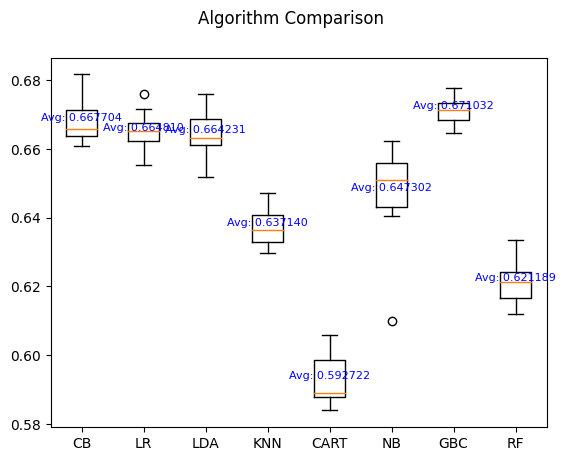

In [326]:
X=data_scaled
Y=target_scaled

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('CB', CatBoostClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
#models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
 kfold = model_selection.KFold(n_splits=10,shuffle=True, random_state=seed)
 cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
 results.append(cv_results)
 names.append(name)
 msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
 print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

averages = [np.mean(result) for result in results]


for i, avg in enumerate(averages):
    ax.text(i + 1, avg, f'Avg: {avg:.6f}', ha='center', va='bottom', fontsize=8, color='blue')


plt.show()

In [ ]:
X=df_all_infos
Y=list_3

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
#models.append(('CB', CatBoostClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
#models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
 kfold = model_selection.KFold(n_splits=10,shuffle=True, random_state=seed)
 cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
 results.append(cv_results)
 names.append(name)
 msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
 print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
#ax.set_xticklabels(names)
plt.show()

In [ ]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

averages = [np.mean(result) for result in results]


for i, avg in enumerate(averages):
    ax.text(i + 1, avg, f'Avg: {avg:.6f}', ha='center', va='bottom', fontsize=8, color='blue')


plt.show()

In [ ]:
durchschnitte=[]
for array in results:
    durchschnitt = sum(array) / len(array)
    durchschnitte.append(durchschnitt)

print("Durchschnitte der Arrays:", durchschnitte)

#SHAP

In [ ]:
!pip install shap
import shap
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization

from shap import TreeExplainer, Explanation
from shap.plots import waterfall


In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

Erklärung für gesamtes Modell

In [ ]:


# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [ ]:
len(shap_values[0])

In [ ]:
#shap.force_plot(explainer.expected_value, shap_values, X_train)

In [ ]:
shap_values = shap.TreeExplainer(clf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
shap.dependence_plot('case:RequestedAmount', shap_values, X_train)

In [ ]:
check = shap.Explanation(shap_values[0])

In [ ]:
shap_values[0]

In [ ]:
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_train)

In [ ]:
shap_values[0]

In [ ]:
shap.plots.waterfall(shap_values[0])

Erklärung für einen Datenpunkt !

In [ ]:
shap_values = explainer.shap_values(new_df_data)


In [ ]:
shap.summary_plot(shap_values, new_df_data)


In [ ]:
shap.force_plot(explainer.expected_value,
                shap_values[0],
                new_df_data)


In [ ]:
shap.decision_plot(explainer.expected_value, shap_values[0], new_df_data)


In [ ]:
shap.plots.beeswarm(shap_values)


#test verschiedener Bucketing methoden

single bucketing

In [ ]:
d = {}
i=0
for i in range(21):

#generate log prefixes for all events that end with "A_Pending", last events, after "A_Pending" are deleted
#in the end, keep a df of all traces that end with A_Pending
 if i <=15:
  i += 1
 else:
  from pm4py.objects.log.obj import EventLog, Trace
  # generate prefixes, note that we need to add the casts to EventLog and Trace to make sure that the result is a PM4Py EventLog object
  log_prefixes_Accepted = pm4py.filter_prefixes(log, 'A_Pending', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
  log_prefixes_Denied = pm4py.filter_prefixes(log, 'A_Denied', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
  log_prefixes_Cancelled = pm4py.filter_prefixes(log, 'A_Cancelled', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')

  log_prefixes_Accepted["label"] = "accepted"
  log_prefixes_Cancelled["label"] = "not"
  log_prefixes_Denied["label"] = "not"

  #generate df of log prefixes with length = value in length
  trimmed_log_Accepted = pm4py.get_prefixes_from_log(log_prefixes_Accepted, length=i, case_id_key='case:concept:name')
  trimmed_log_Denied = pm4py.get_prefixes_from_log(log_prefixes_Denied, length=i, case_id_key='case:concept:name')
  trimmed_log_Cancelled = pm4py.get_prefixes_from_log(log_prefixes_Cancelled, length=i, case_id_key='case:concept:name')

  data_labeled_prefixes= pd.concat([trimmed_log_Accepted, trimmed_log_Denied, trimmed_log_Cancelled], axis=0)
  #print(data_labeled_prefixes.head(10))

  id_counts = data_labeled_prefixes['case:concept:name'].value_counts()

  # IDs auswählen, die genau i-mal auftreten
  valid_ids = id_counts[id_counts == i].index

  # DataFrame filtern, um nur die ausgewählten IDs zu behalten
  filtered_df = data_labeled_prefixes[data_labeled_prefixes['case:concept:name'].isin(valid_ids)]
  filtered_df['NeueSpalte'] = 'data_labeled_prefixes{0}'.format(i)     #nur wichtig für single Bucketing versuch !
  filtered_df['new_id'] = filtered_df['NeueSpalte'] + filtered_df['case:concept:name'] #nur wichtig für single Bucketing versuch !
  filtered_df['case:concept:name'] = filtered_df['new_id'] #nur wichtig für single Bucketing versuch !
  filtered_df = filtered_df.drop(["new_id","NeueSpalte"],axis=1) #nur wichtig für single Bucketing versuch !
  d['data_labeled_prefixes{0}'.format(i)] = filtered_df



  i+=1

  print(i)




In [ ]:
dataframes_list = list(d.values())

# Alle DataFrames in der Liste zusammenführen
combined_dataframe = pd.concat(dataframes_list)

# Das ursprüngliche Dictionary löschen, wenn Sie es nicht mehr benötigen
del d
del dataframes_list

single bucketing encoding

In [ ]:
#das Funktioniert !
#Spalten einfach die dynamic event cat. angeben
spalten = ['concept:name',
           'org:resource',
           'EventOrigin']
ergebnis_df = pd.DataFrame()

# Erstellen Sie eine Pivot-Tabelle für jede Spalte in der Liste
pivot_tables = []
for spalte in spalten:
    pivot_table = pd.pivot_table(combined_dataframe, values='label', index='case:concept:name', columns=spalte, aggfunc='count', fill_value=0, sort=False)
    pivot_tables.append(pivot_table)


# Ergebnisse anzeigen
#for spalte, pivot_table in zip(spalten, pivot_tables):
 #   if ergebnis_df.empty:
  #      ergebnis_df = pivot_table
   # else:
    #    ergebnis_df = ergebnis_df.join(pivot_table, on=spalte, rsuffix=f'_{spalte}')

    #print(f"Pivot-Tabelle für Spalte {spalte}:")
    #print(pivot_table)
    #print("\n")

#print(len(pivot_tables[1]))

In [ ]:
#fügt alle dynamic cat event attributes in ein df.

combined_df = pd.concat([pivot_tables[0], pivot_tables[1],
                         #pivot_tables[2]
                         ])

df_dynamic_event_cat = combined_df.groupby(combined_df.index, sort=False).agg('first',)

# Ergebnis anzeigen
#print(df_dynamic_event_cat)

# Ergebnis anzeigen
#print(combined_df)

In [ ]:
#static trace cat
work_around = pd.DataFrame()
work_around = combined_dataframe[['case:concept:name',
                               "case:LoanGoal",
                               'case:ApplicationType',
                               'case:RequestedAmount',
                               "label"]]
work_around = work_around.drop_duplicates()
work_around = work_around.set_index("case:concept:name")




In [ ]:
work_around_feature_table = pd.get_dummies(work_around)
#work_around_feature_table

In [ ]:
#Labels extrahieren

list_1 = work_around['label'].tolist()

condition = "accepted"

# Verwenden Sie eine List Comprehension, um die Umwandlung durchzuführen
list_2 = [item == condition for item in list_1]

# Jetzt enthält List2 boolesche Werte
print(list_2)
list_3 = np.asarray(list_2).astype(int)
print(list_3)


In [ ]:
#DF all infos
df_all_infos = pd.concat([df_dynamic_event_cat,work_around_feature_table])

In [ ]:
df_all_infos = df_all_infos.groupby(df_all_infos.index, sort=False).agg('first',)
df_all_infos = df_all_infos.drop(["label_accepted","label_not"],axis=1)
# Ergebnis anzeigen
print((df_all_infos))

##FINALES ENCODEDED DF FÜR ML ALGO !!!!!!!!

#Evaluation noch alter Code, muss angepasst werden

In [ ]:
test_dataloader = DataLoader(data, batch_size=256, shuffle=False)
result, original = evaluate_all(test_dataloader, clf, device)

In [ ]:
pd_pos = pd.DataFrame({'Returns': result[original == 1]})
pd_neg = pd.DataFrame({'Does not return': result[original == 0]})
pd.concat([pd_pos, pd_neg],axis=1).boxplot().set_ylabel('Score')

In [ ]:
# count the unique vectors
dist_bags = np.unique(data_bag, return_counts=True, axis=0)

# sort them with numpy
unique_vectors = dist_bags[0][np.argsort(-dist_bags[1])]
count_vectors = dist_bags[1][np.argsort(-dist_bags[1])]

pd.DataFrame({'Occurrence of unique sample vectors': count_vectors}).boxplot().set_ylabel('Frequency')

In [ ]:
# most frequently used vector
unique_vectors[0]

In [ ]:
# find the sample indicies for this vector
sample_indicies = np.where((data_bag == unique_vectors[0]).all(axis=1))
sample_durations = target_scaled[sample_indicies]

In [ ]:
np.unique(sample_durations, return_counts=True)